## Loading of Stringer spontaneous data

includes some visualizations

In [24]:
from collections import defaultdict

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import scipy.stats

In [17]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title Data loading

dat = np.load('../../data/stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [4]:
dat["beh_svd_time"][0].shape

(1000,)


dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [6]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


In [7]:
for k, v in dat.items():
  print("Key: {}".format(k))
  print(v.shape)
  # try:
  #   print(v[:5,:5,:5])
  # except:
  #   print(v[:5,:5])


Key: sresp
(11983, 7018)
Key: run
(7018, 1)
Key: beh_svd_time
(7018, 1000)
Key: beh_svd_mask
(240, 320, 1000)
Key: stat
(11983, 1)
Key: pupilArea
(7018, 1)
Key: pupilCOM
(7018, 2)
Key: xyz
(3, 11983)


In [8]:
dat["sresp"][0]

array([ 2.9820833,  8.409119 , 12.720393 , ...,  0.       , 11.900859 ,
        7.5612717], dtype=float32)

# Neural EDA

## Deconvlving the neural activity

In [45]:
# compute deconvolution
from suite2p.extraction import dcnv
import numpy as np

In [51]:
tau = 2.0 # timescale of indicator
# fs = 30.0 # sampling rate in Hz
fs = 1 # sampling rate in Hz
neucoeff = 0.7 # neuropil coefficient
# for computing and subtracting baseline
baseline = 'maximin' # take the running max of the running min after smoothing with gaussian
sig_baseline = 10.0 # in bins, standard deviation of gaussian with which to smooth
win_baseline = 60.0 # in seconds, window in which to compute max/min filters

ops = {'tau': tau, 'fs': fs, 'neucoeff': neucoeff,
       'baseline': baseline, 'sig_baseline': sig_baseline, 'win_baseline': win_baseline,
      'batchsize': 500}


In [52]:
# load traces and subtract neuropil
Fc = dat["sresp"]

In [53]:
# baseline operation
Fc = dcnv.preprocess(
     F=Fc,
     baseline=ops['baseline'],
     win_baseline=ops['win_baseline'],
     sig_baseline=ops['sig_baseline'],
     fs=ops['fs'],
     # prctile_baseline=ops['prctile_baseline']
 )


In [57]:

# get spikes
spks = dcnv.oasis(F=Fc, batch_size=ops["batchsize"], tau=ops['tau'], fs=ops['fs'])

In [58]:
spks

array([[0.0000000e+00, 4.1391048e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.0411704e+00, 0.0000000e+00],
       [0.0000000e+00, 1.9426782e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.1780296e+01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.2622709e-01,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        6.0082603e+00, 8.4497406e+01],
       [0.0000000e+00, 2.3894440e+01, 9.2651260e+01, ..., 0.0000000e+00,
        0.0000000e+00, 6.5612289e+01],
       [0.0000000e+00, 4.6515699e-02, 1.2800403e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [60]:
z_scored_trace = zscore(dat["sresp"][0])

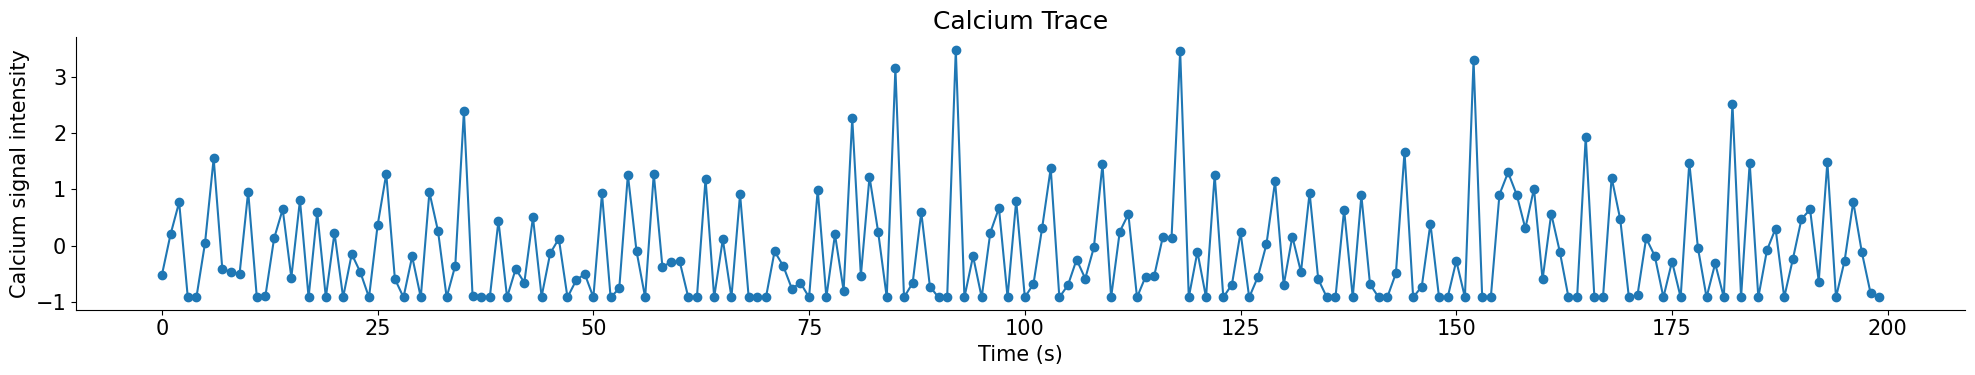

In [61]:

plt.plot(z_scored_trace[:200], marker='o')
plt.title('Calcium Trace')
plt.xlabel('Time (s)')
plt.ylabel('Calcium signal intensity')
plt.show()

In [62]:
plt.plot(dat["sresp"][0][:200], marker='o')
plt.title('Calcium Trace')
plt.xlabel('Time (s)')
plt.ylabel('Calcium signal intensity')
plt.show()

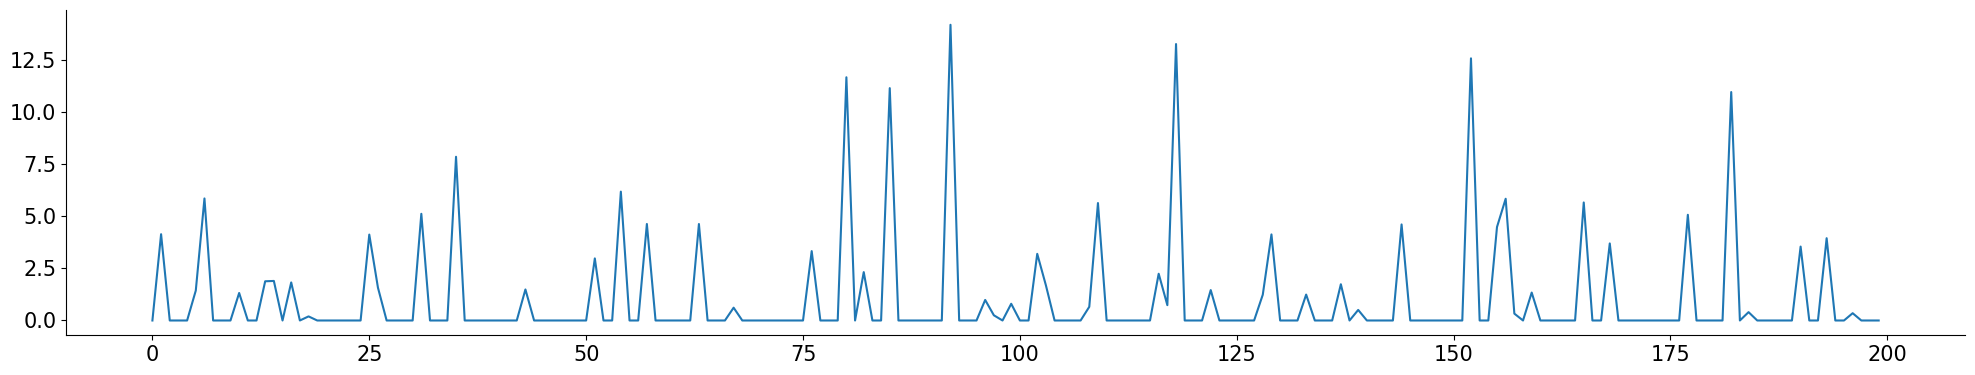

In [63]:
plt.plot(spks[0][:200])

## Spatial Coordinates

- Looking at the spatial coordinates

In [11]:
dat["xyz"].shape

(3, 11983)

### Spatial plotting code from the example

In [20]:
# Separating each coordinate into separate axis
x, y, z = dat['xyz']

In [19]:
x.shape

(11983,)

In [22]:
all_depths = np.unique(z)

In [23]:
all_depths

array([-390., -360., -330., -300., -270., -240., -210., -180., -150.])

In [28]:
depth_to_neural = defaultdict(dict)

In [35]:
for depth in all_depths:
    depth_to_neural[depth]["neural_index"] = np.where(z == depth)[0]

In [39]:
depth_to_neural[-150]["neural_index"].shape

(1131,)

In [38]:
depth_to_neural[-390]["neural_index"].shape

(1386,)

### Plotting based on layers

In [44]:
zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

C:\Users\Leo\AppData\Local\Temp\ipykernel_66820\4245094710.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


In [69]:
spks[:,10].shape

(11983,)

(array([1.1913e+04, 4.3000e+01, 1.2000e+01, 8.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([   0.        ,  125.51595306,  251.03190613,  376.54785156,
         502.06381226,  627.57977295,  753.09570312,  878.61169434,
        1004.12762451, 1129.64355469, 1255.1595459 ]),
 <BarContainer object of 10 artists>)

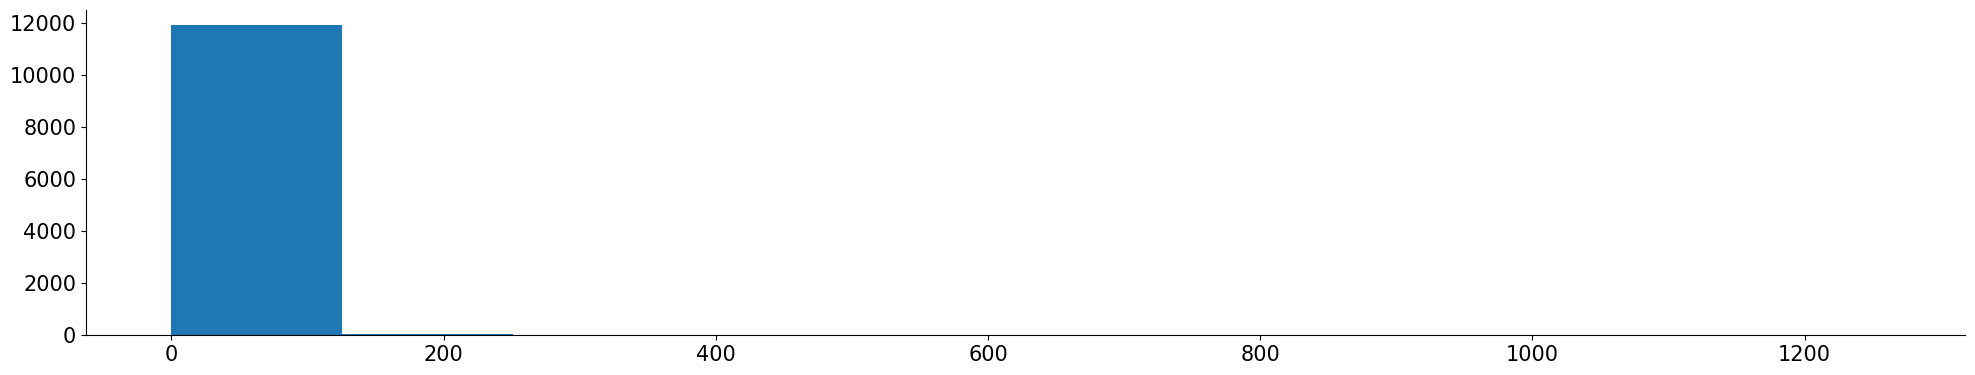

In [71]:
plt.hist(spks[:,10])

In [76]:
from matplotlib.cm import ScalarMappable


C:\Users\Leo\AppData\Local\Temp\ipykernel_66820\3295232839.py:5: RuntimeWarning: divide by zero encountered in log
  sc = ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=np.log(spks[:,num]), cmap='hot')


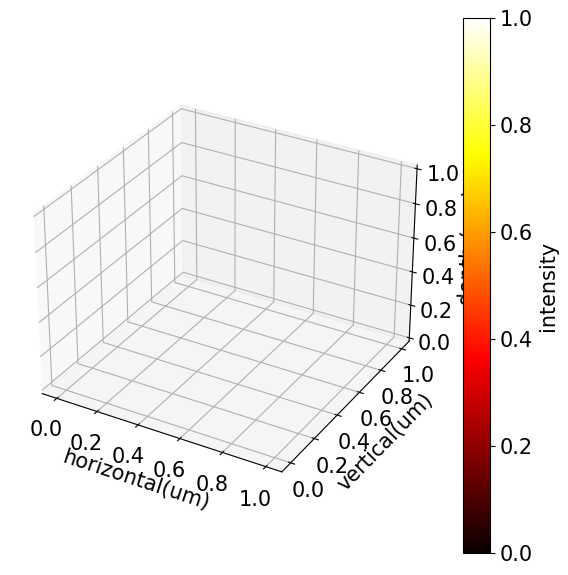

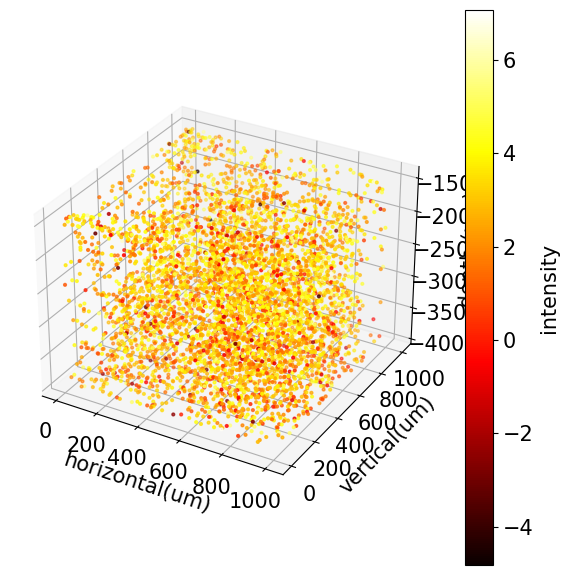

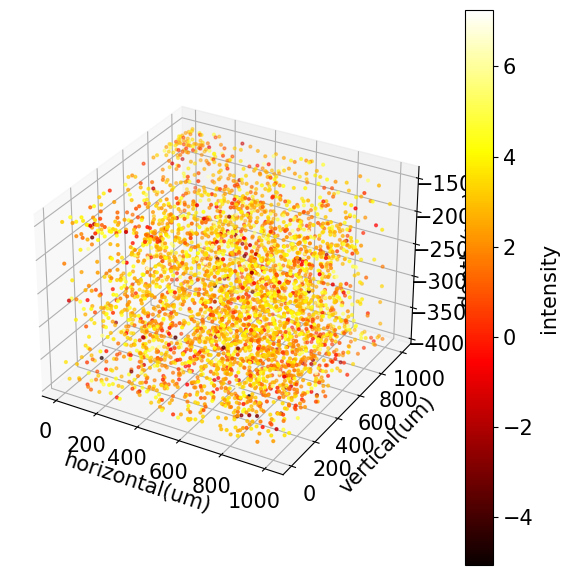

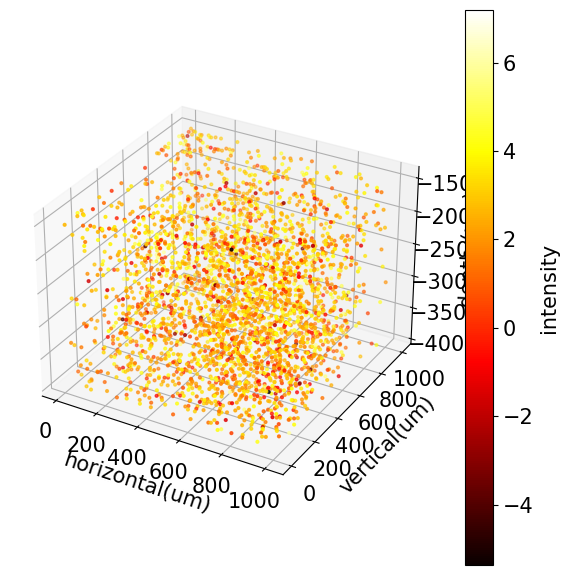

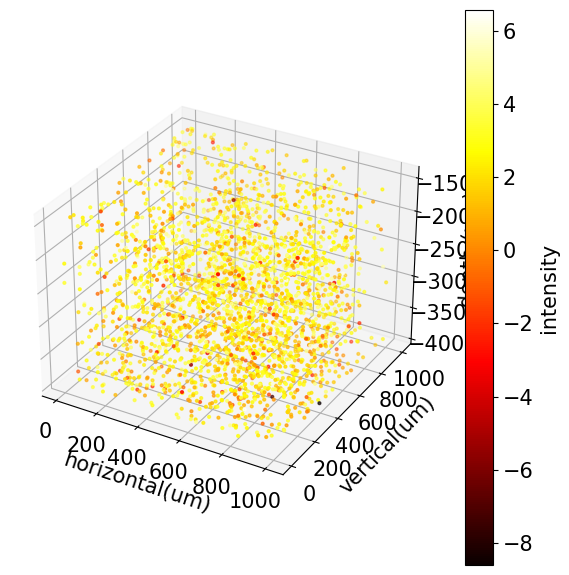

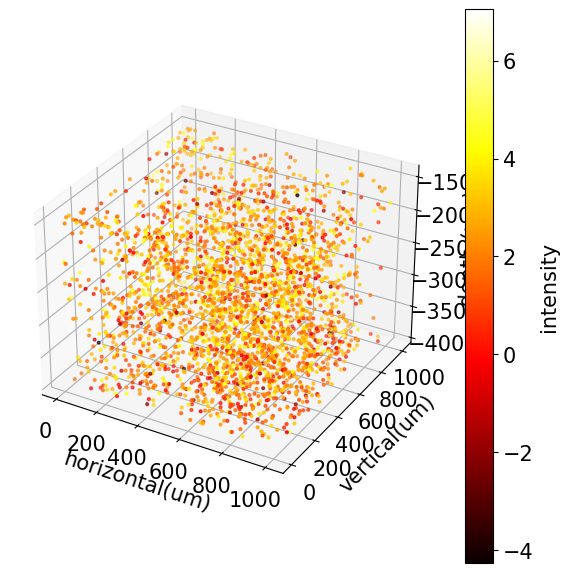

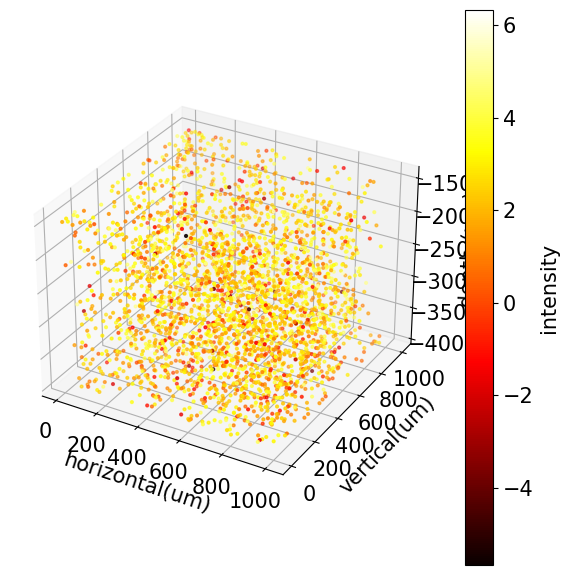

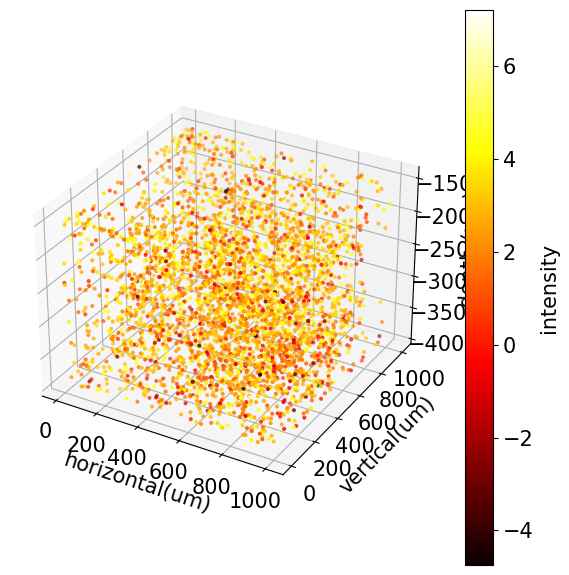

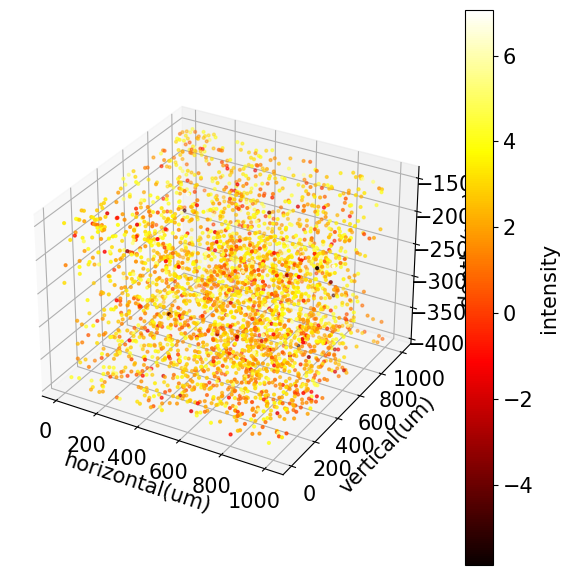

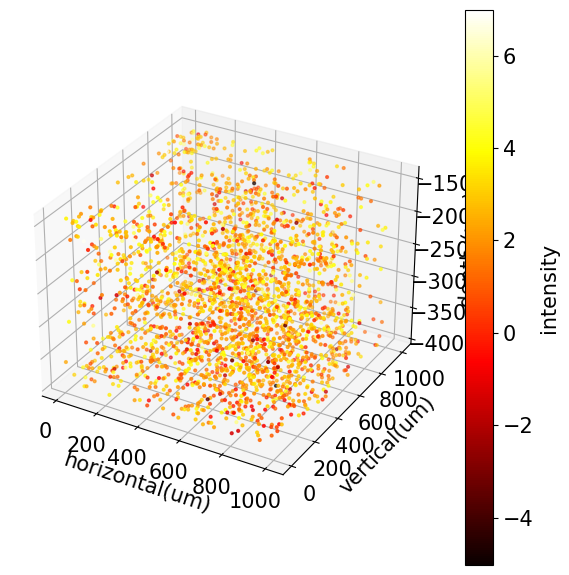

In [170]:
# for num in range(len(spks[:])):
for num in range(10):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=np.log(spks[:,num]), cmap='hot')
    ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
    
    # add a colorbar
    plt.colorbar(sc, label='intensity')
    plt.tight_layout()
    plt.show()

(array([1386., 1440., 1418., 1471.,    0., 1415., 1321., 1218., 1183.,
        1131.]),
 array([-390., -366., -342., -318., -294., -270., -246., -222., -198.,
        -174., -150.]),
 <BarContainer object of 10 artists>)

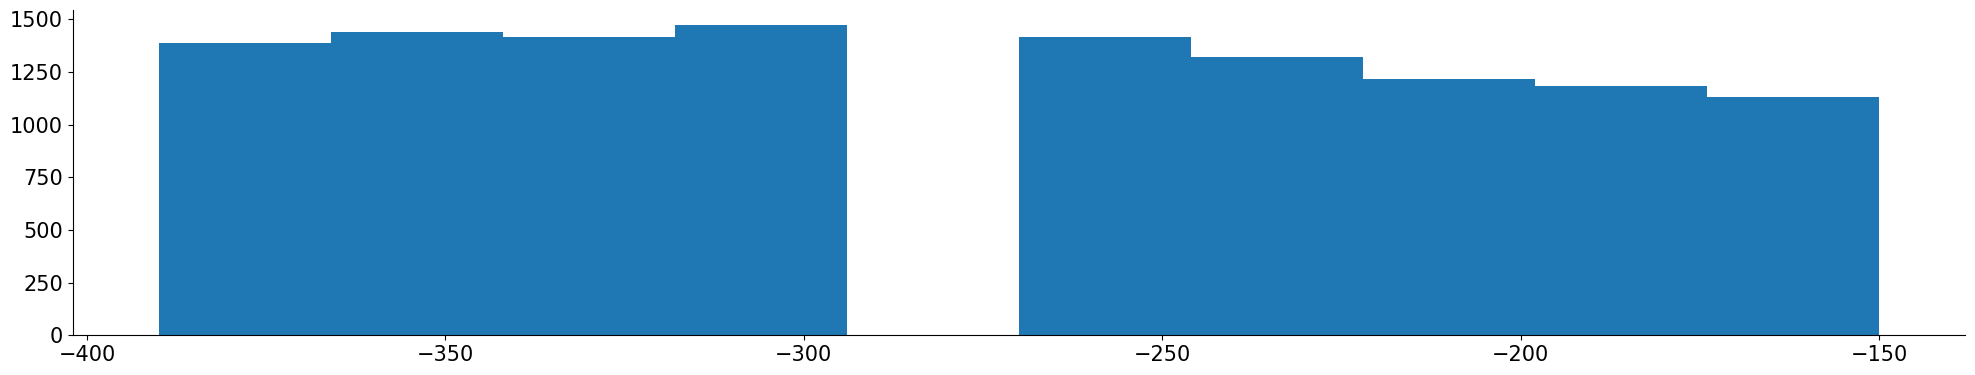

In [16]:
plt.hist(dat["xyz"][2])

## Spatial Dimensionality Reduction

In [210]:
from sklearn.manifold import SpectralEmbedding

In [213]:
dat["xyz"].shape

(3, 11983)

In [215]:
spks.shape

(11983, 7018)

In [211]:

# Assume data is a numpy array with shape (n_neurons, n_timebins + 2)
# where the first two columns are the x and y coordinates of each neuron
# and the remaining columns are the firing rates.
data = np.random.rand(1000, 102)

# Separate spatial coordinates and firing rates
coordinates = data[:, :2]
firing_rates = data[:, 2:]

# Apply Laplacian Eigenmaps
embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
low_dim_data = embedding.fit_transform(firing_rates)

# Now low_dim_data contains a 2D representation of your firing rates that respects the spatial configuration of your neurons.

## Pupil Area Analysis

In [163]:
pupil_area = dat['pupilArea'][:,0]

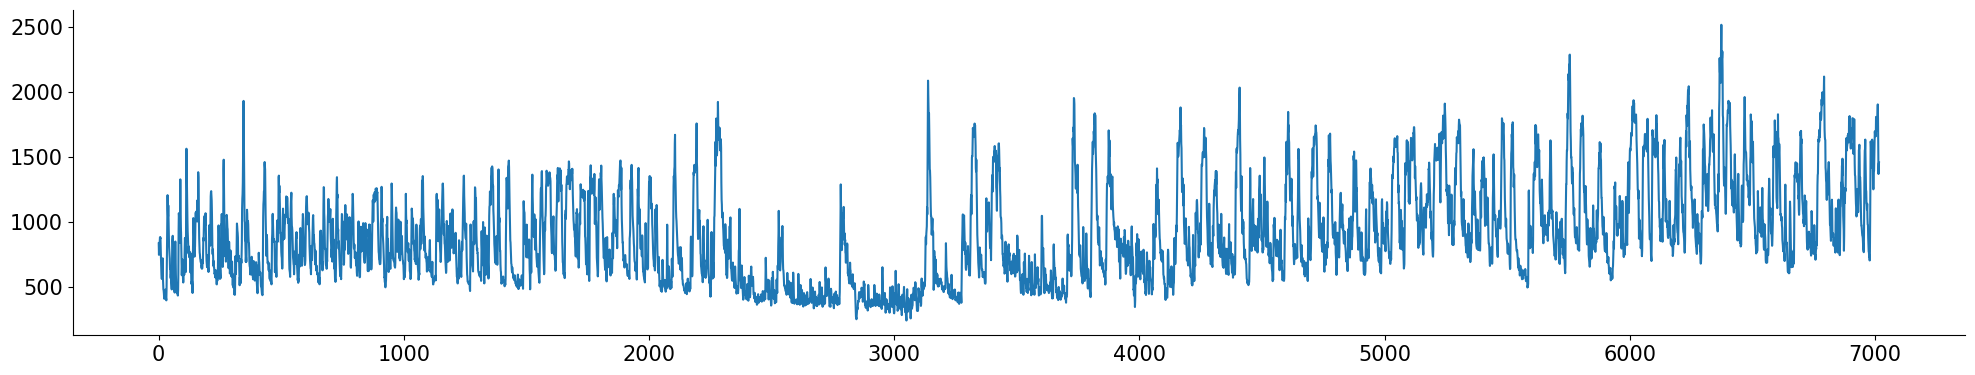

In [164]:
plt.plot(pupil_area)

(array([ 704., 1669., 1828., 1178.,  724.,  501.,  331.,   61.,   19.,
           3.]),
 array([ 238.46559326,  466.66464208,  694.86369091,  923.06273974,
        1151.26178857, 1379.4608374 , 1607.65988623, 1835.85893506,
        2064.05798389, 2292.25703272, 2520.45608155]),
 <BarContainer object of 10 artists>)

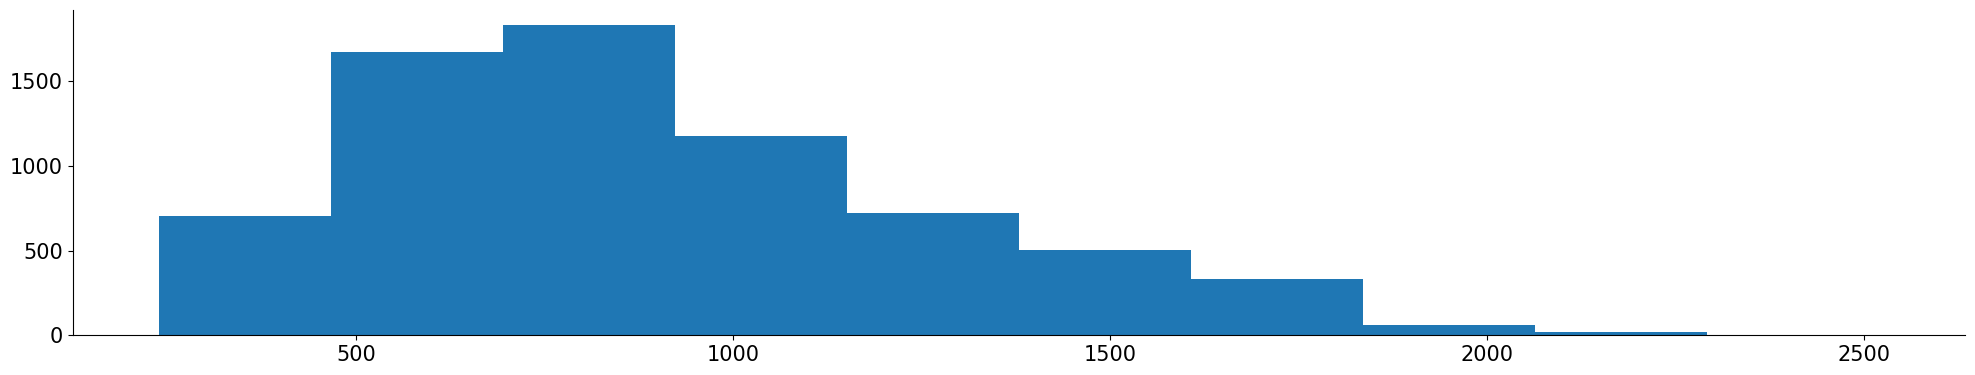

In [165]:
plt.hist(pupil_area)

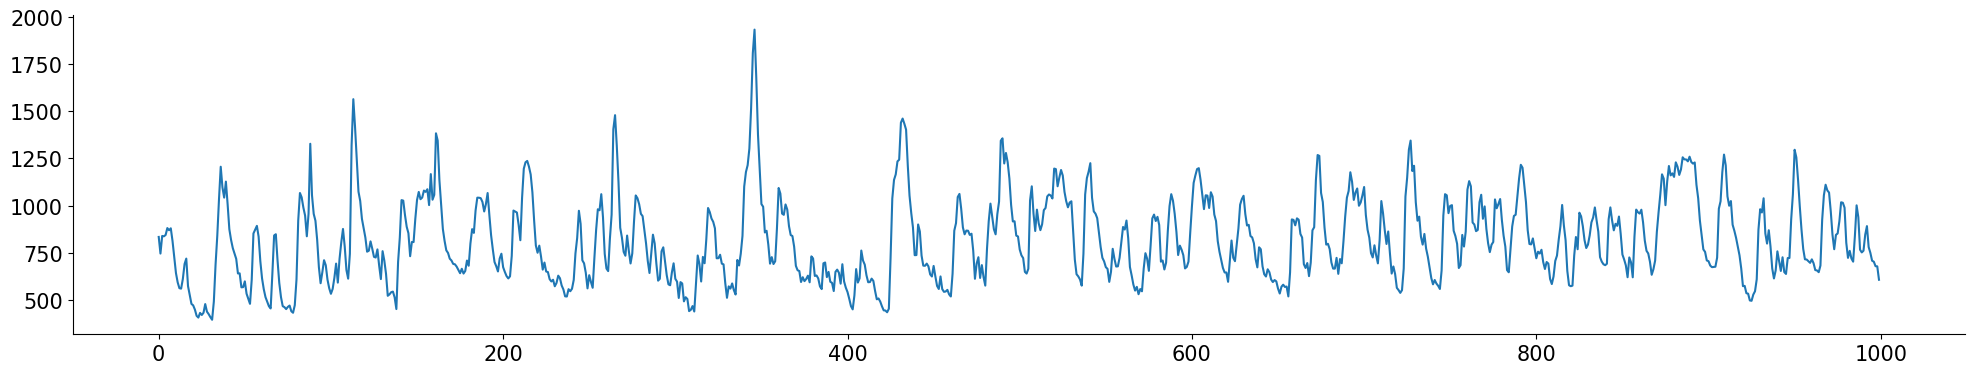

In [173]:
plt.plot(pupil_area[:1000])

### Getting the times when pupil area is highest

In [200]:
pupil_area = pupil_area[:1000]

In [201]:
pupil_z_scores = scipy.stats.zscore(pupil_area)

(array([ 81., 279., 252., 194., 120.,  53.,  15.,   3.,   1.,   2.]),
 array([-1.90550055, -1.20696553, -0.50843051,  0.19010451,  0.88863953,
         1.58717455,  2.28570957,  2.9842446 ,  3.68277962,  4.38131464,
         5.07984966]),
 <BarContainer object of 10 artists>)

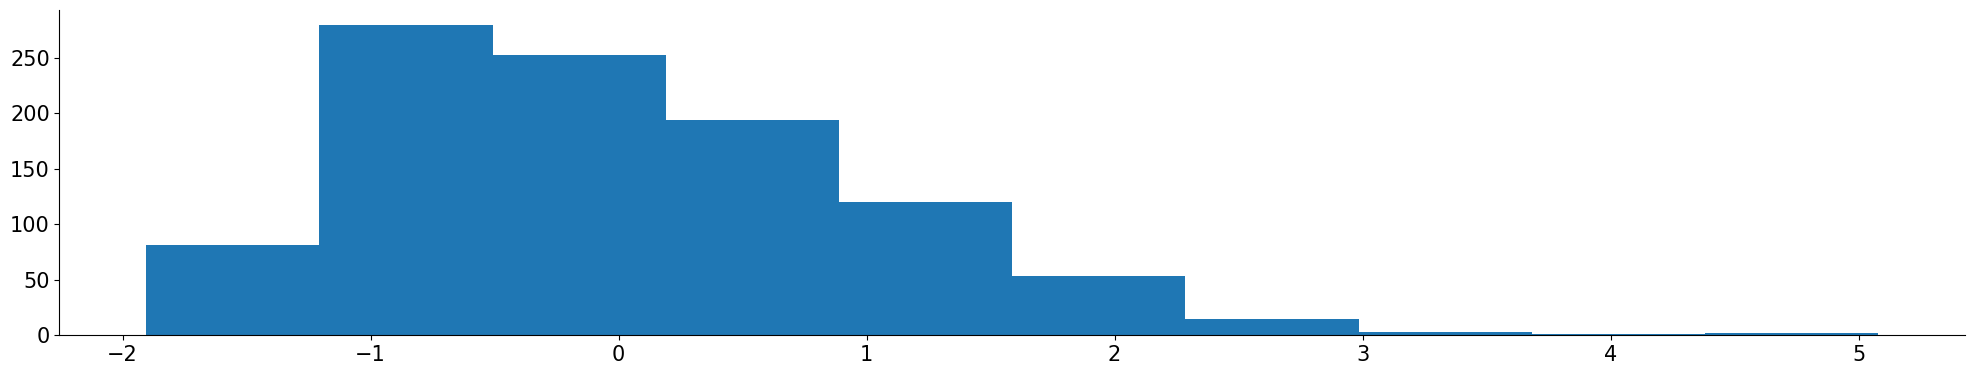

In [202]:
plt.hist(pupil_z_scores)

In [203]:
def first_in_consecutive_sequence(lst):
    result = [lst[0]]  # first number is always included
    for i in range(1, len(lst)):
        if lst[i] - lst[i-1] != 1:
            result.append(lst[i])
    return result

In [204]:
np.where(pupil_z_scores > 2.5)[0]

array([113, 114, 161, 264, 265, 344, 345, 346, 347, 348, 431, 432, 433,
       434], dtype=int64)

In [205]:
high_pupil_area_indexes = np.where(pupil_z_scores > 2.5)[0]

In [206]:
high_pupil_area_indexes

array([113, 114, 161, 264, 265, 344, 345, 346, 347, 348, 431, 432, 433,
       434], dtype=int64)

In [207]:
high_pupil_area_indexes = first_in_consecutive_sequence(high_pupil_area_indexes)

In [208]:
high_pupil_area_indexes

[113, 161, 264, 344, 431]

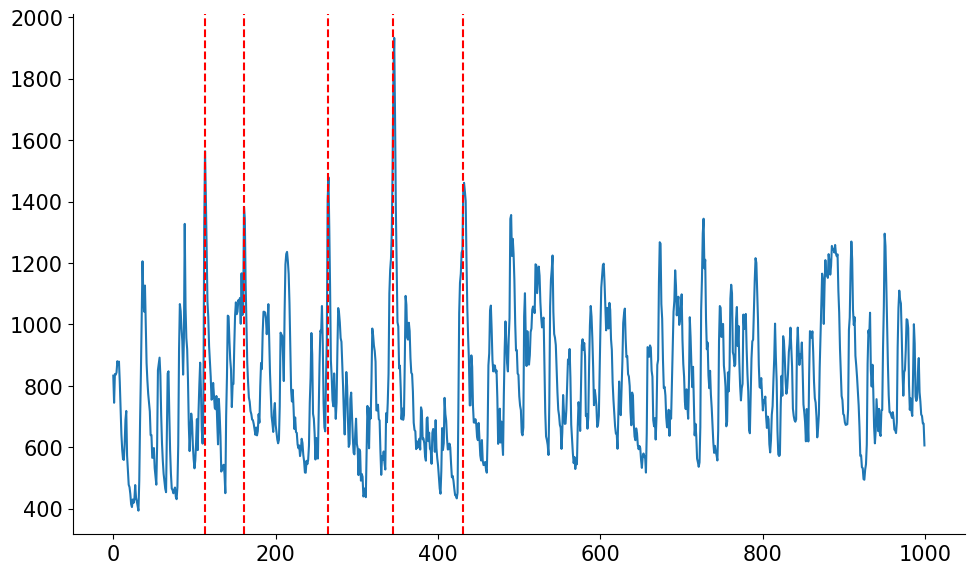

In [209]:
# Plot the data and the detected spikes
plt.figure(figsize=(10, 6))
plt.plot(pupil_area)
for t in high_pupil_area_indexes:
    plt.axvline(x=t, color='r', linestyle='--')
plt.show()

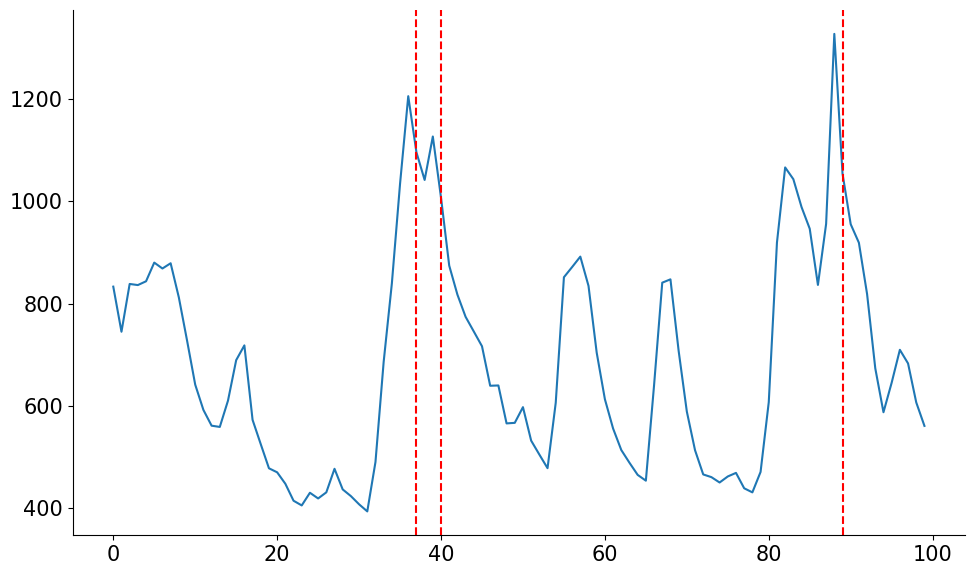

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Here, "data" is your 1D numpy array with pupil area measurements.
# data = np.array([...])

# Define the threshold value for detecting a sharp increase.
# This should be based on your understanding of what constitutes a "sharp" increase in the specific context of your data.
threshold = 1100

# Compute the difference between consecutive measurements.
diff = np.diff(pupil_area,n=20)

# Find the indices where the difference exceeds the threshold.
# These indices correspond to the end points of the sharp increases.
spike_times = np.where(pupil_area > threshold)[0] + 1  # +1 to point to the end of the increase

# Now, `spike_times` is a 1D numpy array that contains the time points of all sharp increases.

# Plot the data and the detected spikes
plt.figure(figsize=(10, 6))
plt.plot(pupil_area)
for t in spike_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.show()

In [156]:
import ruptures as rpt


# Define the model ("l1", "rbf", "linear", "normal", "ar"...) and the detection method
model = "l1"  # "l1" model computes the sum of absolute errors, suitable for abrupt changes.
algo = rpt.Pelt(model=model).fit(pupil_area)

# Set the penality value. 
# Higher values will lead to fewer change points.
penalty_value = 1
result = algo.predict(pen=penalty_value)

# Filter the change points to keep only the positive changes
positive_change_points = [result[i] for i in range(1, len(result)-1) if pupil_area[result[i]] - pupil_area[result[i-1]] > 100]

In [157]:
positive_change_points

[35, 55, 70, 80, 85]

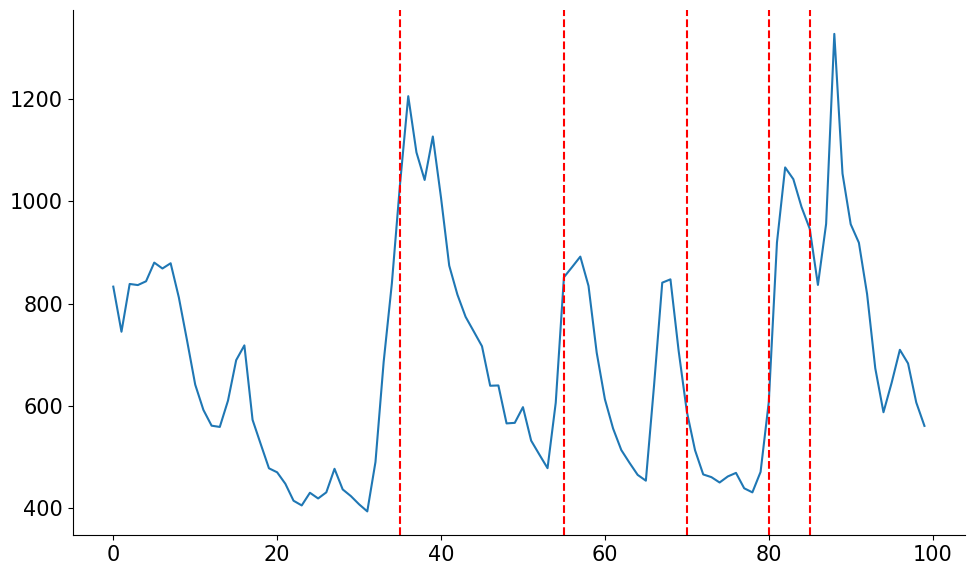

In [158]:
# Display the data and the positive change points
plt.figure(figsize=(10, 6))
plt.plot(pupil_area)
for cp in positive_change_points:
    plt.axvline(x=cp, color='r', linestyle='--')
plt.show()

In [159]:
# Display the data and the change points
rpt.display(pupil_area, positive_change_points, figsize=(10, 6))
plt.show()

In [105]:
# Assume pupil_area is a 1D numpy array of your pupil area data
smoothed_pupil_area = np.convolve(pupil_area, np.ones(5)/5, mode='valid')

# Calculate the derivative
derivative = np.diff(smoothed_pupil_area)

# Choose a threshold
threshold = 0.1

# Find the indices where the derivative surpasses the threshold
trial_starts = np.where(derivative > threshold)[0]
trial_ends = np.where(derivative < threshold)[0]

# Make sure we start with a trial start and end with a trial end
if trial_starts[0] > trial_ends[0]:
    trial_ends = trial_ends[1:]
if trial_starts[-1] > trial_ends[-1]:
    trial_starts = trial_starts[:-1]

# Extract the trials
trials = [smoothed_pupil_area[start:end] for start, end in zip(trial_starts, trial_ends)]

In [ ]:
raise ValueError("OLD STUFF)

In [8]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

C:\Users\Leo\AppData\Local\Temp\ipykernel_24132\1627216238.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


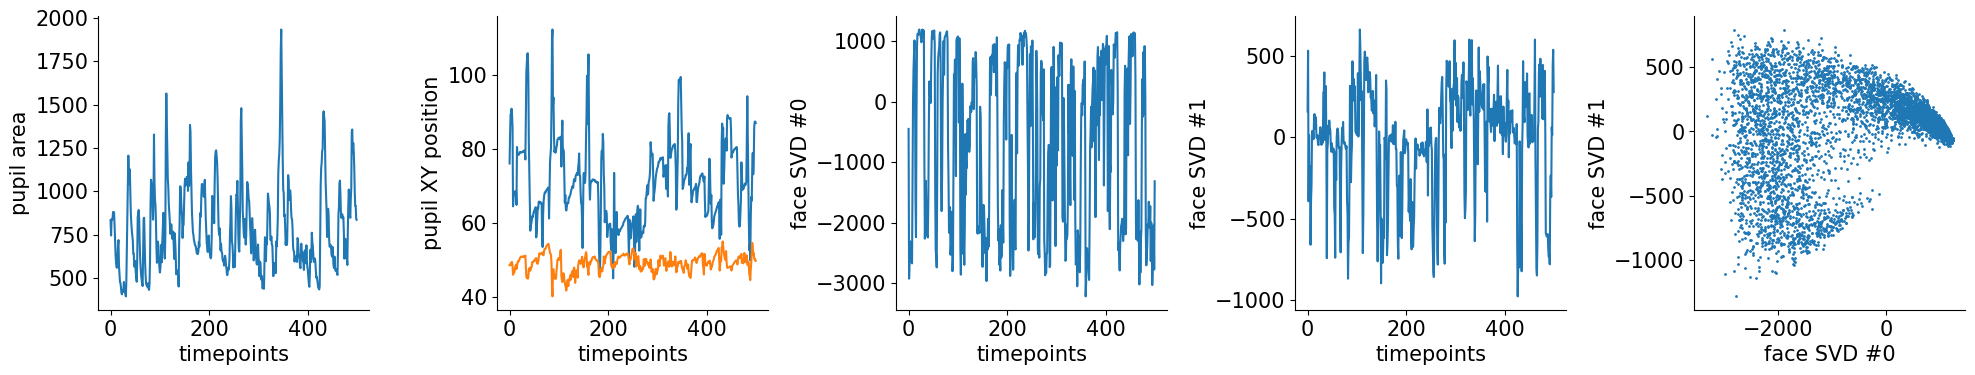

In [9]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

In [10]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)

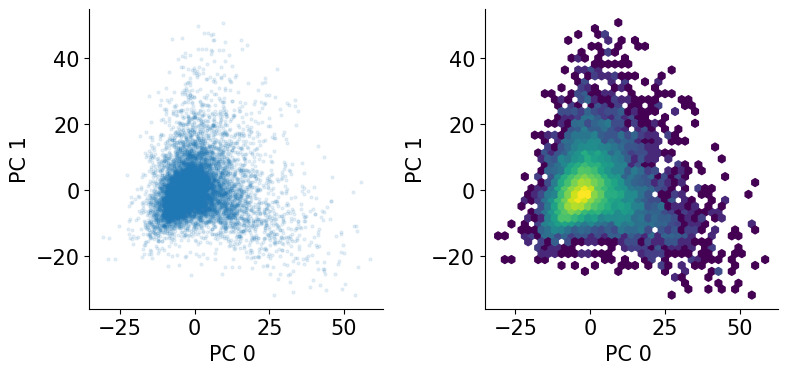

In [11]:
# @title Plot PCs. Too many points, switch to logarithmic hexbin!
ax = plt.subplot(1, 5, 1)
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=.1)
ax.set(xlabel='PC 0 ', ylabel='PC 1')

ax = plt.subplot(1, 5, 2)
plt.hexbin(X[:, 0], X[:, 1], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 1', alpha=.1)

plt.show()

In [12]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions.

ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=20,
             metric='correlation', transform_seed=42).fit_transform(X)

In [13]:
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

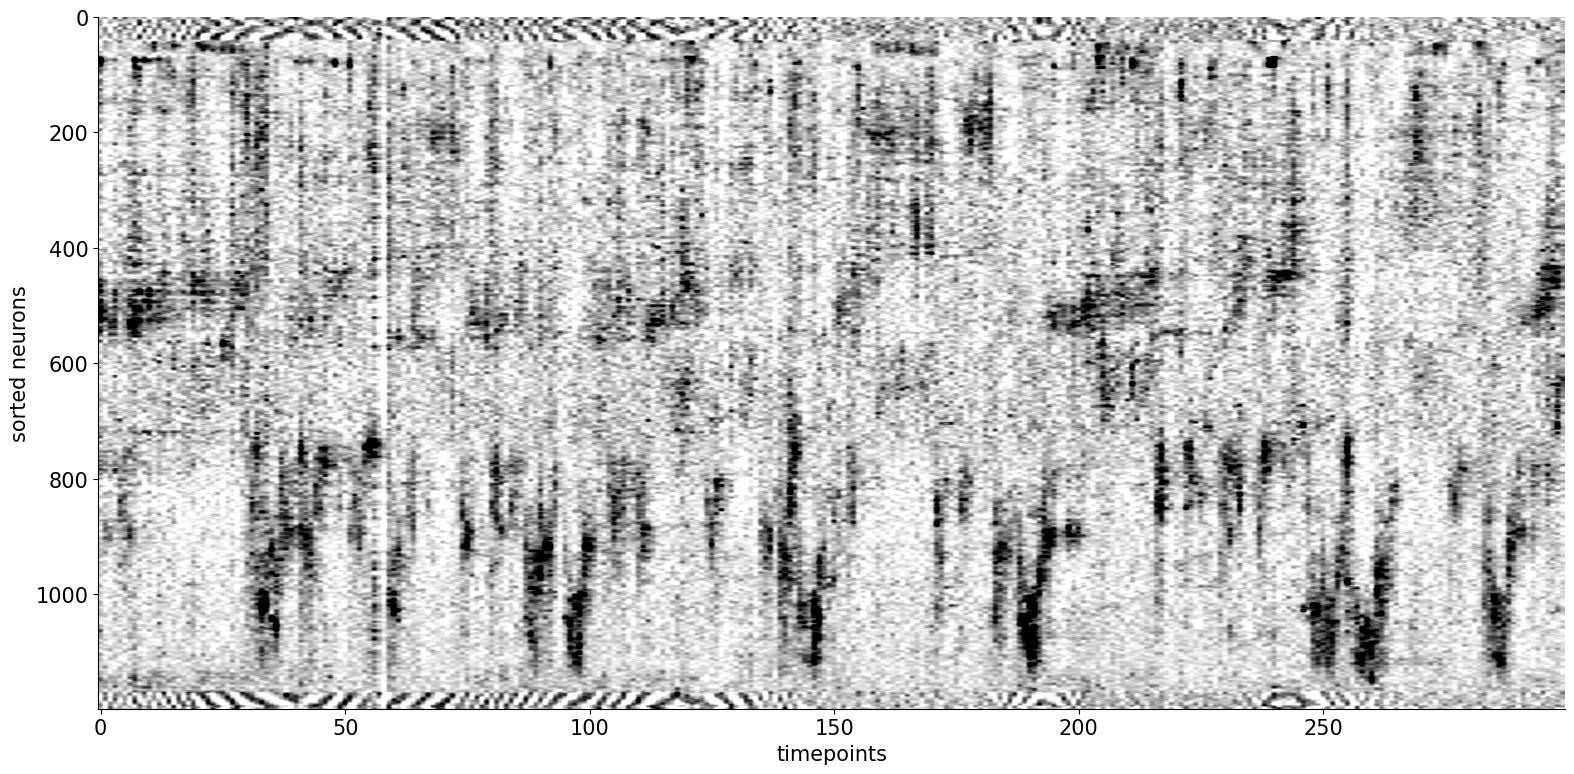

In [14]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='sorted neurons')
plt.show()

In [15]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture